# Imports

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer, quantile_transform
from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import r2_score, mean_squared_error

# Load data

In [ ]:
data = pd.read_csv('data/Dataset.csv', index_col=0)

data.head()

,instant,date,season,year,month,hour,weekday,weather,temperature,feeling_temperature,humidity,windspeed,Subscribed,Non-subscribed,Total
0,1,2011-01-01,winter,0,Jan,0,Sat,Clear or partly cloudy,3.28,3.0014,81.0,0.0,3,13,16
1,2,2011-01-01,winter,0,Jan,1,Sat,Clear or partly cloudy,2.34,1.9982,80.0,0.0,8,32,40
2,3,2011-01-01,winter,0,Jan,2,Sat,Clear or partly cloudy,2.34,1.9982,80.0,0.0,5,27,32
3,4,2011-01-01,winter,0,Jan,3,Sat,Clear or partly cloudy,3.28,3.0014,75.0,0.0,3,10,13
4,5,2011-01-01,winter,0,Jan,4,Sat,Clear or partly cloudy,3.28,3.0014,75.0,0.0,0,1,1


# EDA

## Feature correlation

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text major ticklabel objects>)

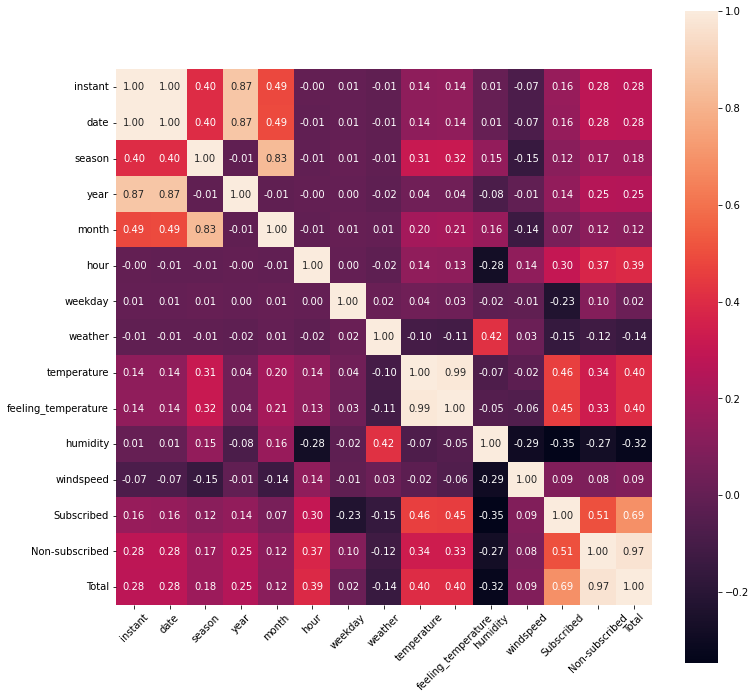

In [ ]:
def get_x(data):

  data_transformed = data.copy()

  columns = ["date", "season", "month", "weekday", "weather"]

  for column in columns:
    data_transformed[column] = pd.factorize(data[column])[0]

  return data_transformed

X = get_x(data)

plt.figure(figsize=(12, 12))

corr_matrix = X.corr()

# plot the heatmap and annotation on it
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True, square=True, fmt=".2f")

plt.xticks(rotation=45)

## Time components distribution

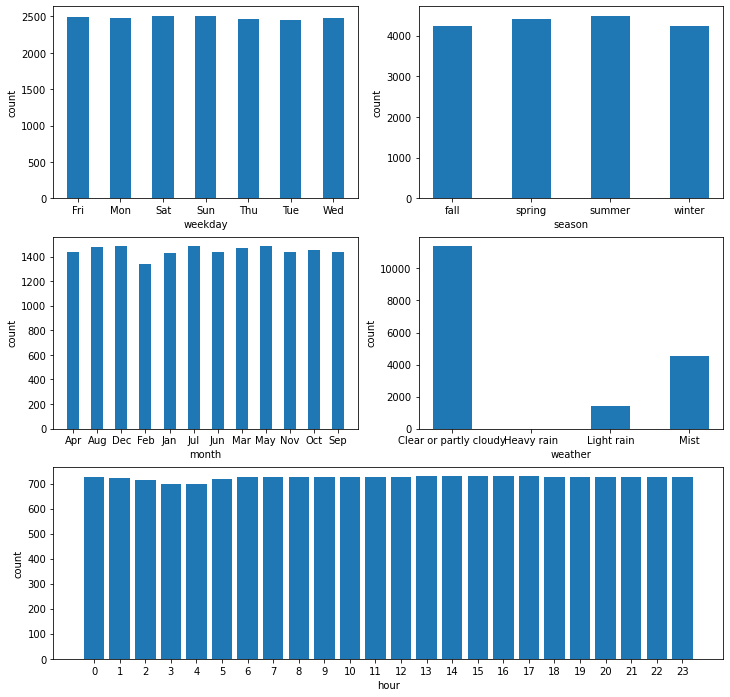

In [ ]:
columns = ["weekday", "season", "month", "weather", "hour"] 

fig = plt.figure(figsize=(12, 12))

grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.2)

for index, column in enumerate(columns):

  grouped_df = data.groupby(by=[column])["instant"].count().reset_index()

  if index < 4:
    ax = plt.subplot(grid[int(index/2), index%2])
    ax.bar(np.arange(grouped_df[column].nunique()), grouped_df["instant"].to_list(), align="center", width=0.5)
  else:
    ax = plt.subplot(grid[int(index/2), index%2:])
    ax.bar(np.arange(grouped_df[column].nunique()), grouped_df["instant"].to_list(), align="center")

  ax.set_xlabel(column)
  ax.set_ylabel("count")
  ax.set_xticks(np.arange(grouped_df[column].nunique()))
  ax.set_xticklabels(grouped_df[column].unique())

plt.show()

## Temperature, Feeling temperature, Windspeed and Humidity Distribution

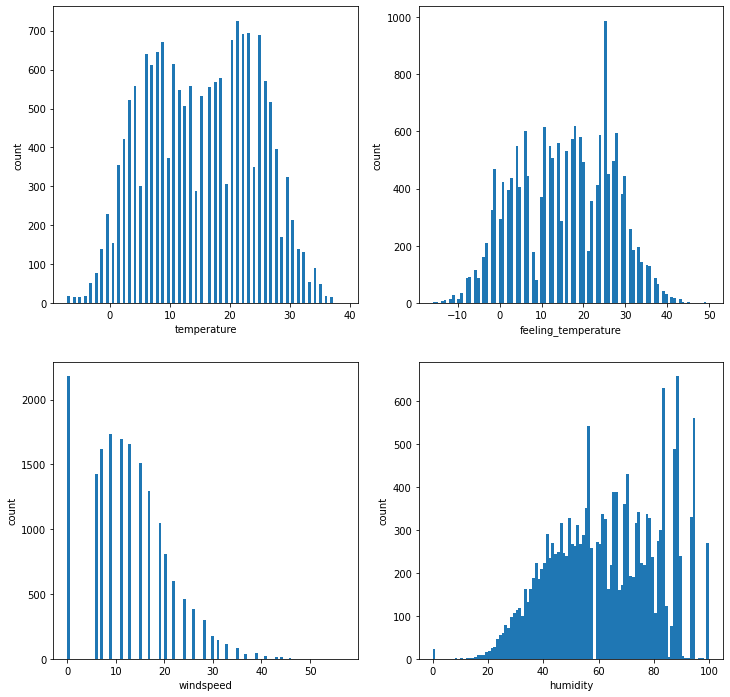

In [ ]:
columns = ["temperature", "feeling_temperature", "windspeed", "humidity"] 

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for index, column in enumerate(columns):

  ax[int(index/2), int(index%2)].hist(x=data[column].to_list(), bins=100)

  ax[int(index/2), int(index%2)].set_xlabel(column)
  ax[int(index/2), int(index%2)].set_ylabel("count")

plt.show()

## Subscriber, Non Subscriber and Total rentals distribution

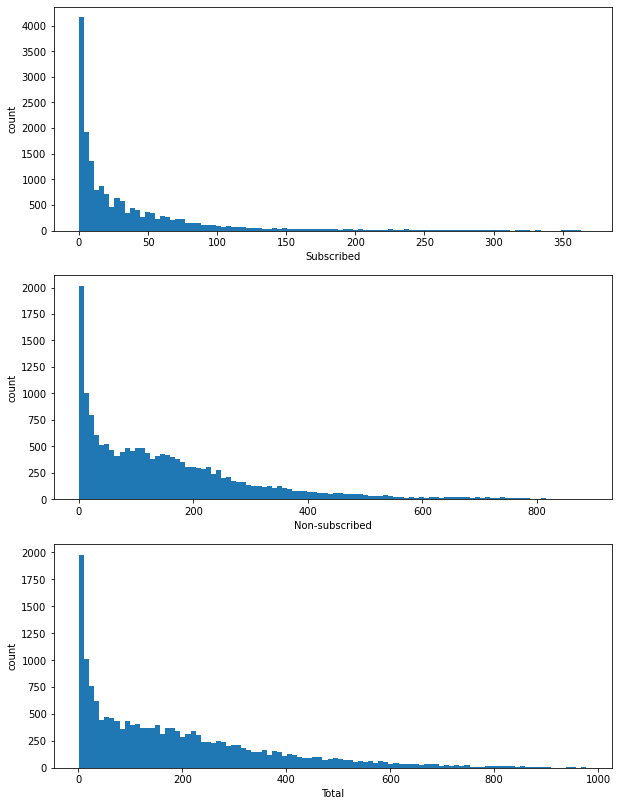

In [ ]:
columns = ["Subscribed", "Non-subscribed", "Total"] 

fig, ax = plt.subplots(3, 1, figsize=(10, 14))

for index, column in enumerate(columns):

  ax[index].hist(x=data[column].to_list(), bins=100)

  ax[index].set_xlabel(column)
  ax[index].set_ylabel("count")

plt.show()

## Hourly customer trends

- Subcribed vs Non subscribed
- Across seasons
- Across Weather
- Day of week
- Month of year

In [ ]:
hourly_grouped = data.groupby(by=['hour'])['Total'].mean().reset_index()

hourly_customer_type_grouped = data.groupby(by=['hour'])['Subscribed', 'Non-subscribed'].mean().reset_index()

hourly_season_grouped = data.groupby(by=['season', 'hour'])['Total'].mean().reset_index()

hourly_weather_grouped = data.groupby(by=['weather', 'hour'])['Total'].mean().reset_index()

hourly_day_of_week_grouped = data.groupby(by=['weekday', 'hour'])['Total'].mean().reset_index()

hourly_month_grouped = data.groupby(by=['month', 'hour'])['Total'].mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


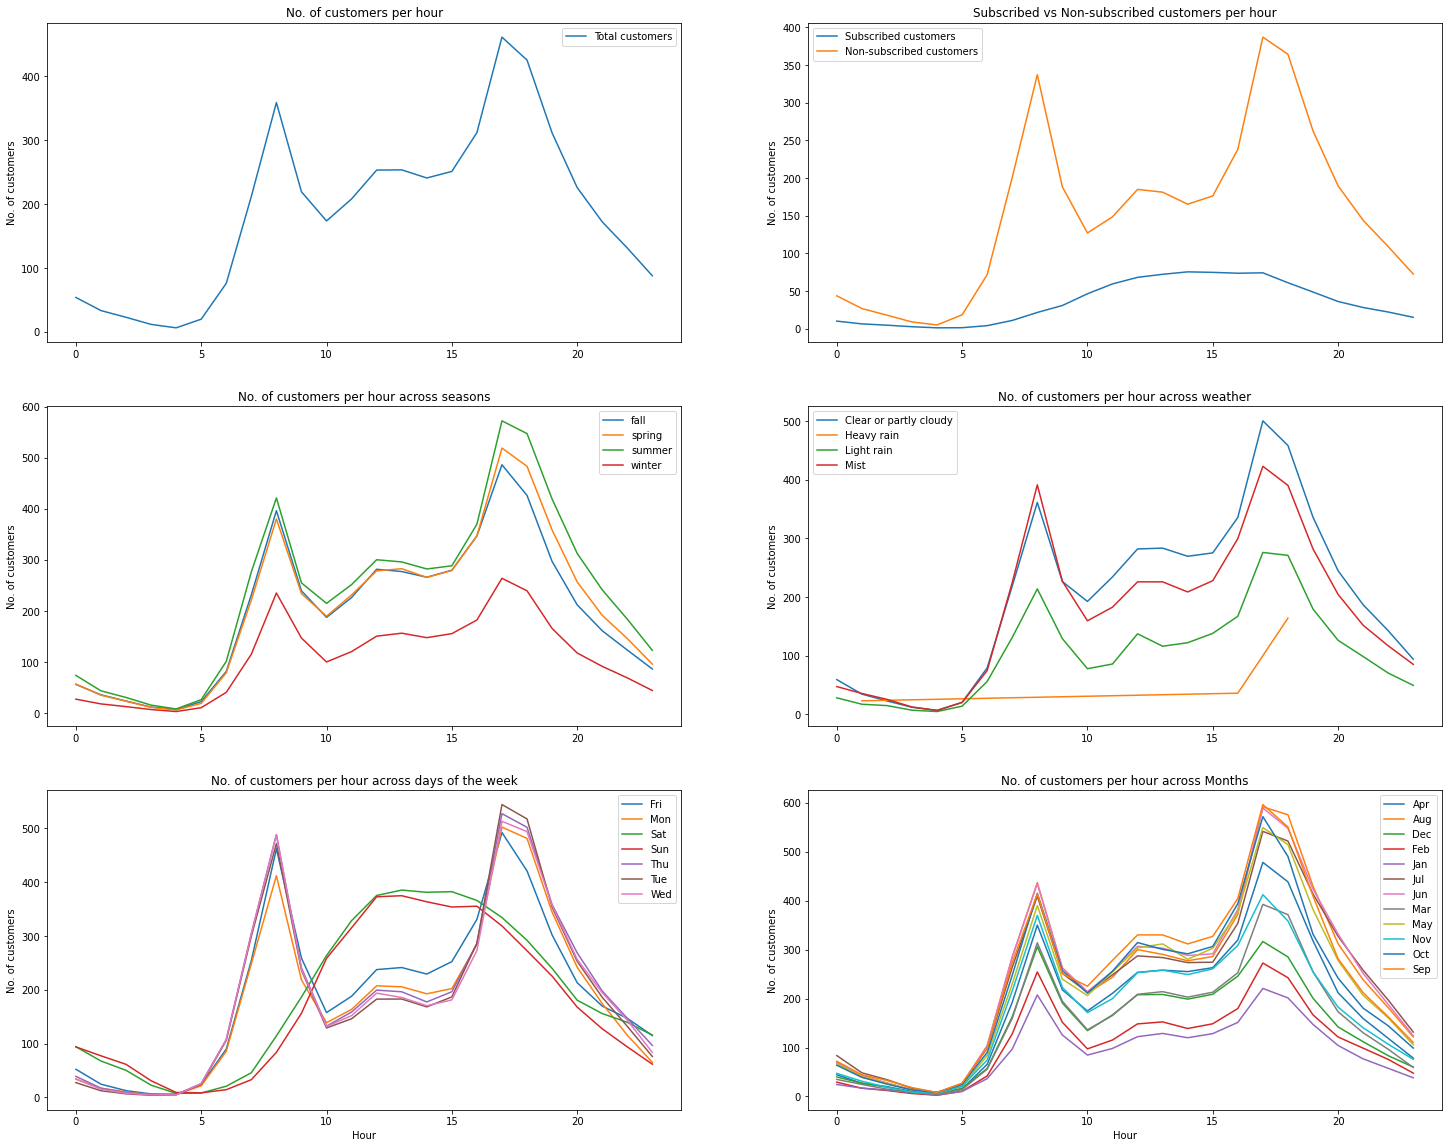

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25, 20), squeeze=True)

ax[0, 0].plot(hourly_grouped['hour'], hourly_grouped['Total'], label='Total customers')
# ax[0, 0].set_xlabel('Hour')
ax[0, 0].set_ylabel('No. of customers')
ax[0, 0].legend()
ax[0, 0].set_title('No. of customers per hour')


ax[0, 1].plot(hourly_customer_type_grouped['hour'], hourly_customer_type_grouped['Subscribed'], label='Subscribed customers')
ax[0, 1].plot(hourly_customer_type_grouped['hour'], hourly_customer_type_grouped['Non-subscribed'], label='Non-subscribed customers')
# ax[0, 1].set_xlabel('Hour')
ax[0, 1].set_ylabel('No. of customers')
ax[0, 1].legend()
ax[0, 1].set_title('Subscribed vs Non-subscribed customers per hour')


for season in hourly_season_grouped['season'].unique():

  ax[1, 0].plot(hourly_season_grouped[hourly_season_grouped['season'] == season]['hour'], hourly_season_grouped[hourly_season_grouped['season'] == season]['Total'], label=season)

# ax[1, 0].set_xlabel('Hour')
ax[1, 0].set_ylabel('No. of customers')
ax[1, 0].legend()
ax[1, 0].set_title('No. of customers per hour across seasons')


for weather in hourly_weather_grouped['weather'].unique():

  ax[1, 1].plot(hourly_weather_grouped[hourly_weather_grouped['weather'] == weather]['hour'], hourly_weather_grouped[hourly_weather_grouped['weather'] == weather]['Total'], label=weather)

# ax[1, 1].set_xlabel('Hour')
ax[1, 1].set_ylabel('No. of customers')
ax[1, 1].legend()
ax[1, 1].set_title('No. of customers per hour across weather')


for weekday in hourly_day_of_week_grouped['weekday'].unique():

  ax[2, 0].plot(hourly_day_of_week_grouped[hourly_day_of_week_grouped['weekday'] == weekday]['hour'], hourly_day_of_week_grouped[hourly_day_of_week_grouped['weekday'] == weekday]['Total'], label=weekday)

ax[2, 0].set_xlabel('Hour')
ax[2, 0].set_ylabel('No. of customers')
ax[2, 0].legend()
ax[2, 0].set_title('No. of customers per hour across days of the week')


for month in hourly_month_grouped['month'].unique():

  ax[2, 1].plot(hourly_month_grouped[hourly_month_grouped['month'] == month]['hour'], hourly_month_grouped[hourly_month_grouped['month'] == month]['Total'], label=month)

ax[2, 1].set_xlabel('Hour')
ax[2, 1].set_ylabel('No. of customers')
ax[2, 1].legend()
ax[2, 1].set_title('No. of customers per hour across Months')


plt.show()

## Hourly Subscribed vs Non-subscribed trends

- Across weekday
- Across month
- Across year

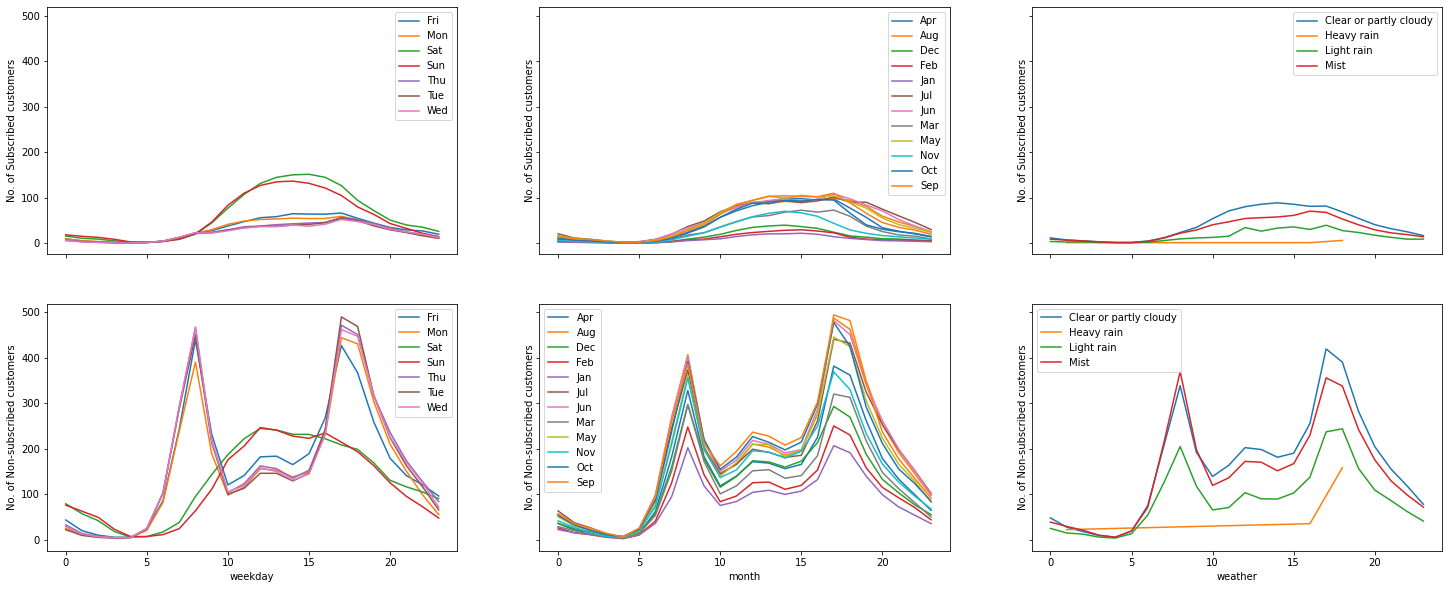

In [ ]:
grouped_data = {
  'Subscribed': {
    'weekday': data.groupby(by=['weekday', 'hour'])['Subscribed'].mean().reset_index(),
    'month': data.groupby(by=['month', 'hour'])['Subscribed'].mean().reset_index(),
    'weather': data.groupby(by=['weather', 'hour'])['Subscribed'].mean().reset_index()
  },
  'Non-subscribed': {
    'weekday': data.groupby(by=['weekday', 'hour'])['Non-subscribed'].mean().reset_index(),
    'month': data.groupby(by=['month', 'hour'])['Non-subscribed'].mean().reset_index(),
    'weather': data.groupby(by=['weather', 'hour'])['Non-subscribed'].mean().reset_index()
  }
}


fig, ax = plt.subplots(2, 3, figsize=(25, 10), sharex=True, sharey=True, squeeze=True)

for i, (customer_type, customer_grouped_data) in enumerate(grouped_data.items()):

  for j, (grouping_label, grouped_data) in enumerate(customer_grouped_data.items()):

    for grouping_category in grouped_data[grouping_label].unique():

      ax[i, j].plot(grouped_data[grouped_data[grouping_label] == grouping_category]['hour'], grouped_data[grouped_data[grouping_label] == grouping_category][customer_type], label=grouping_category)

    if i == 1:
      ax[i, j].set_xlabel(grouping_label)
      
    ax[i, j].set_ylabel(f'No. of {customer_type} customers')
    ax[i, j].legend()

plt.show()

## Effect of windspeed

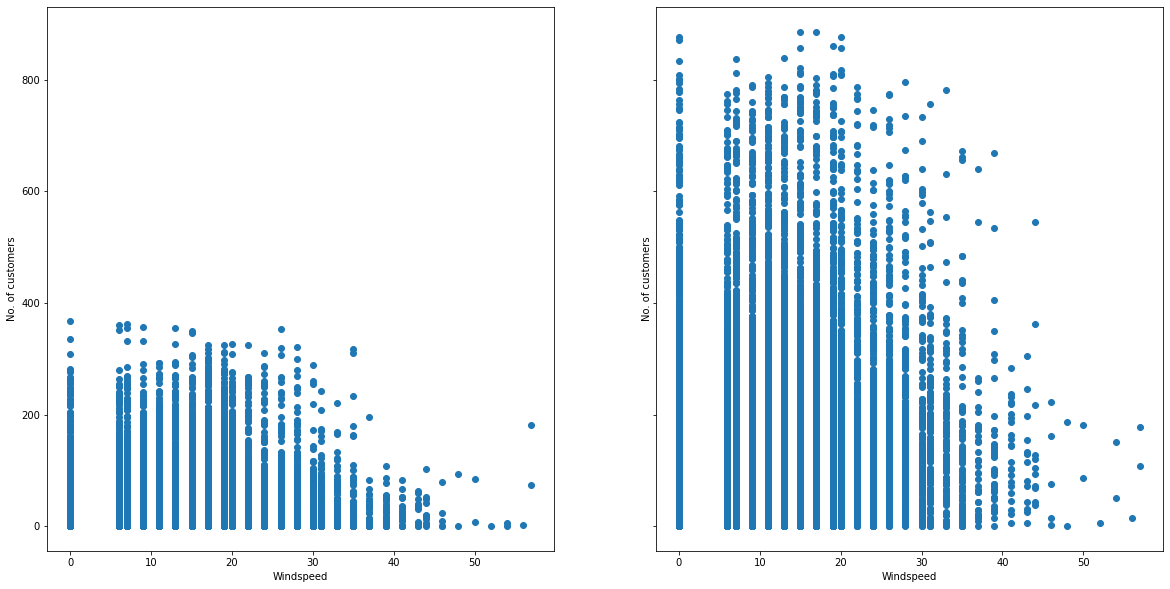

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].scatter(data['windspeed'], data['Subscribed'], label='Subscribed')
ax[0].set_xlabel('Windspeed')
ax[0].set_ylabel('No. of customers')

ax[1].scatter(data['windspeed'], data['Non-subscribed'], label='Non-subscribed')
ax[1].set_xlabel('Windspeed')
ax[1].set_ylabel('No. of customers')

plt.show()

## Effect of temperature

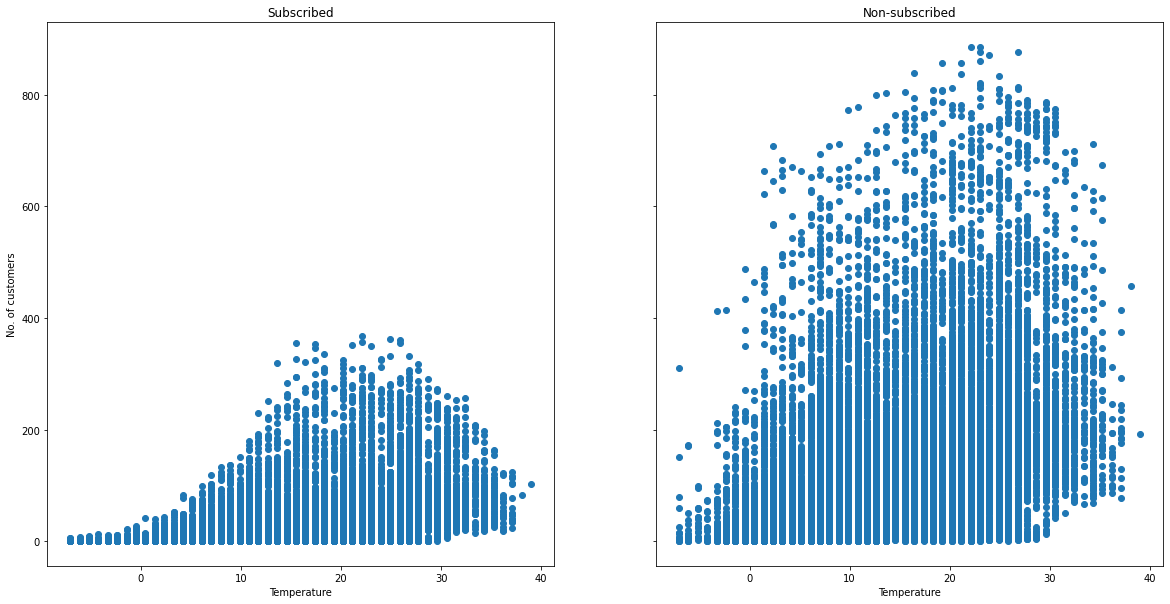

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].scatter(data['temperature'], data['Subscribed'], label='Subscribed')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('No. of customers')
ax[0].set_title('Subscribed')

ax[1].scatter(data['temperature'], data['Non-subscribed'], label='Non-subscribed')
ax[1].set_xlabel('Temperature')
ax[1].set_title('Non-subscribed')

plt.show()

## Effect of feeling_temperature

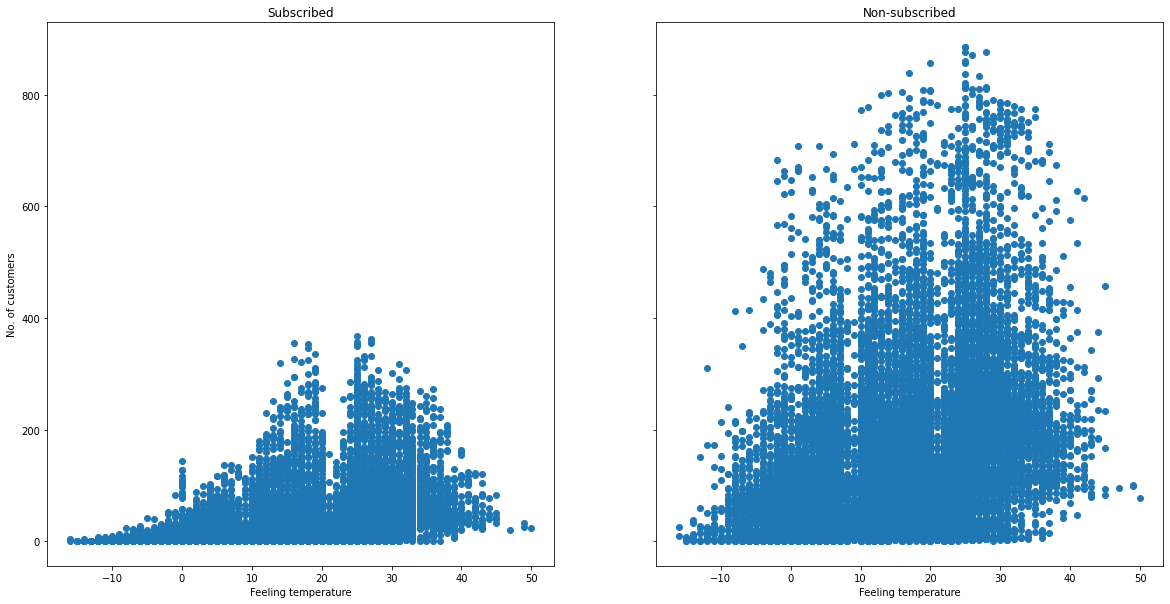

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].scatter(data['feeling_temperature'], data['Subscribed'], label='Subscribed')
ax[0].set_xlabel('Feeling temperature')
ax[0].set_ylabel('No. of customers')
ax[0].set_title('Subscribed')

ax[1].scatter(data['feeling_temperature'], data['Non-subscribed'], label='Non-subscribed')
ax[1].set_xlabel('Feeling temperature')
ax[1].set_title('Non-subscribed')

plt.show()

## Effect of humidity

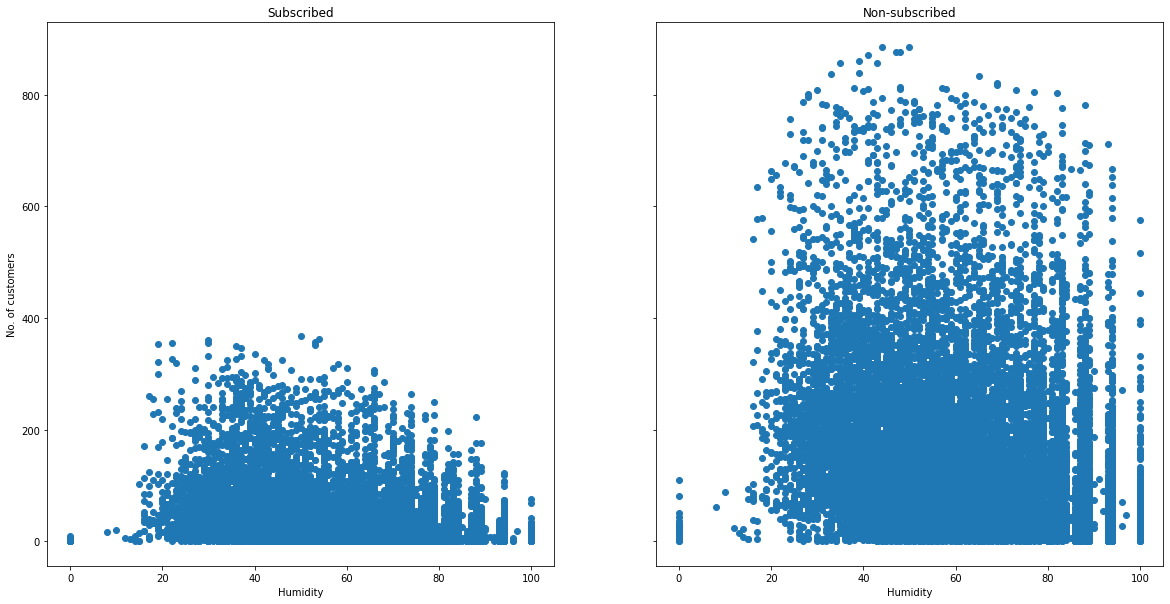

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

ax[0].scatter(data['humidity'], data['Subscribed'], label='Subscribed')
ax[0].set_xlabel('Humidity')
ax[0].set_ylabel('No. of customers')
ax[0].set_title('Subscribed')

ax[1].scatter(data['humidity'], data['Non-subscribed'], label='Non-subscribed')
ax[1].set_xlabel('Humidity')
ax[1].set_title('Non-subscribed')

plt.show()

# Preprocessing
## Replace category label Heavy Rain with Light Rain in weather column

In [ ]:
data["weather"].replace({"Heavy rain": "Light rain"}, inplace=True)

# Linear Regression Model 

## Feature creation

In [ ]:
df = pd.read_csv("data/Dataset.csv")

SelectedColumns = ['season', 'year', 'month', 'hour', 'weekday', 'weather', 'feeling_temperature', 'temperature', 'windspeed', 'humidity', 'Total', 'Subscribed', 'Non-subscribed']

# replacing heavy rain with light rain
df["weather"].replace({"Heavy rain": "Light rain"}, inplace=True)

# replacing Mon-Fri as weekday and Sat-Sun as weekend
df["weekday"].replace({
    "Sat": "weekend",
    "Sun": "weekend",
    "Fri": "weekday",
    "Thu": "weekday",
    "Wed": "weekday",
    "Tue": "weekday",
    "Mon": "weekday"},
  inplace=True)

#Normalise feeling_temperature to [0,1]
min_max_scaler = MinMaxScaler()
feeling_temperature = min_max_scaler.fit_transform(df['feeling_temperature'].to_numpy().reshape(-1, 1))
df['feeling_temperature'] = feeling_temperature

#Normalise temperature to [0,1]
min_max_scaler = MinMaxScaler()
temperature = min_max_scaler.fit_transform(df['temperature'].to_numpy().reshape(-1, 1))
df['temperature'] = temperature

#Normalise humidity to [0,1]
min_max_scaler = MinMaxScaler()
humidity = min_max_scaler.fit_transform(df['humidity'].to_numpy().reshape(-1, 1))
df['humidity'] = humidity

#Normalise windspeed to [0,1]
min_max_scaler = MinMaxScaler()
windspeed = min_max_scaler.fit_transform(df['windspeed'].to_numpy().reshape(-1, 1))
df['windspeed'] = windspeed

year = df['year'].to_numpy().reshape(-1, 1)
df['year'] = year

# Normalise Total
min_max_scaler = MinMaxScaler()
total = min_max_scaler.fit_transform(df['Total'].to_numpy().reshape(-1, 1))
df['Total'] = total

# Normalise Subscribed
min_max_scaler = MinMaxScaler()
subscribed = min_max_scaler.fit_transform(df['Subscribed'].to_numpy().reshape(-1, 1))
df['Subscribed'] = subscribed

# Normalise Non-subscribed
min_max_scaler = MinMaxScaler()
non_subscribed = min_max_scaler.fit_transform(df['Non-subscribed'].to_numpy().reshape(-1, 1))
df['Non-subscribed'] = non_subscribed

# Selecting final columns
DataForML = df[SelectedColumns]
DataForML.dtypes

season                  object
year                     int64
month                   object
hour                     int64
weekday                 object
weather                 object
feeling_temperature    float64
temperature            float64
windspeed              float64
humidity               float64
Total                  float64
Subscribed             float64
Non-subscribed         float64
dtype: object

In [ ]:
# Treating all the nominal variables at once using dummy variables
# OneHotEncode
DataForML_Numeric=pd.get_dummies(DataForML, columns=['season', 'month', 'weekday', 'weather', 'hour'])

# Printing all the column names for our reference
print(DataForML_Numeric.columns)

# Printing sample rows
DataForML_Numeric.head()

Index(['year', 'feeling_temperature', 'temperature', 'windspeed', 'humidity',
       'Total', 'Subscribed', 'Non-subscribed', 'season_fall', 'season_spring',
       'season_summer', 'season_winter', 'month_Apr', 'month_Aug', 'month_Dec',
       'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
       'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
       'weekday_weekend', 'weather_Clear or partly cloudy',
       'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


,year,feeling_temperature,temperature,windspeed,humidity,Total,Subscribed,Non-subscribed,season_fall,season_spring,season_summer,season_winter,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,weekday_weekday,weekday_weekend,weather_Clear or partly cloudy,weather_Light rain,weather_Mist,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0.2879,0.224490,0.0,0.81,0.015369,0.008174,0.014673,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.2727,0.204082,0.0,0.80,0.039959,0.021798,0.036117,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.2727,0.204082,0.0,0.80,0.031762,0.013624,0.030474,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.2879,0.224490,0.0,0.75,0.012295,0.008174,0.011287,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.2879,0.224490,0.0,0.75,0.000000,0.000000,0.001129,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Training and Prediction for Linear Regression model


In [ ]:
def train_predict(dataFrame, predictors, targetVariable):
  X = dataFrame[predictors].values
  y = dataFrame[targetVariable].values

  train_perc = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
  r2_train = []
  r2_test = []
  mse_train = []
  mse_test = []
  fig, ax1 = plt.subplots(figsize=(8, 4))
  test_perc = []

  for i in train_perc:
    test_size = 1-i
    test_perc.append(test_size)
    # Split the data into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=428)

    reg = LinearRegression()

    # Printing all the parameters of Linear regression
    # print(reg)

    # Creating the model on Training Data
    reg.fit(X_train, y_train)

    # predict
    y_train_pred = reg.predict(X_train)

    #print(f'\ni = {i}\n')
    #print('Train R2 Value:\t', metrics.r2_score(y_train, y_train_pred))
    # print('Train MSE:\t', metrics.mean_squared_error(y_train, y_train_pred))
    r2_train.append(r2_score(y_train, y_train_pred))
    mse_train.append(mean_squared_error(y_train, y_train_pred))

    prediction = reg.predict(X_test)
    #print('Test R2 Value:\t', metrics.r2_score(y_test, prediction))
    # print('Test MSE:\t', metrics.mean_squared_error(y_test, prediction))
    r2_test.append(r2_score(y_test, prediction))
    mse_test.append(mean_squared_error(y_test, prediction))

  print(f'Avg R-Square for Training: {np.mean(r2_train)}')
  print(f'Avg R-Square for Testing: {np.mean(r2_test)}')
  print(f'Avg MSE for Training: {np.mean(mse_train)}')
  print(f'Avg MSE for Testing: {np.mean(mse_test)}')
  
  ax1.plot(train_perc, r2_train, label="Train R squared", color='orange', linestyle="dashed")
  ax1.plot(train_perc, r2_test, label="Test R squared", color='orange')
  ax1.legend(loc='upper left')
  ax1.set_xlabel('Training Size')
  # Make the y-axis label, ticks and tick labels match the line color.
  ax1.set_ylabel('R squared', color='orange')
  ax1.tick_params('y', colors='orange')

  ax2 = ax1.twinx()
  ax2.plot(train_perc, mse_train, label="Train MSE", color='deepskyblue', linestyle="dashed")
  ax2.plot(train_perc, mse_test, label="Test MSE", color='deepskyblue')
  ax2.legend(loc='upper right')
  ax2.set_xlabel('Training Size')
  # Make the y-axis label, ticks and tick labels match the line color.
  ax2.set_ylabel('MSE', color='deepskyblue')
  ax2.tick_params('y', colors='deepskyblue')

  fig.tight_layout()
  plt.title(targetVariable)
  plt.show()
  return reg

Avg R-Square for Training: 0.6881521700492458
Avg R-Square for Testing: 0.6740673698740163
Avg MSE for Training: 0.01076662300691868
Avg MSE for Testing: 0.011335655767457485


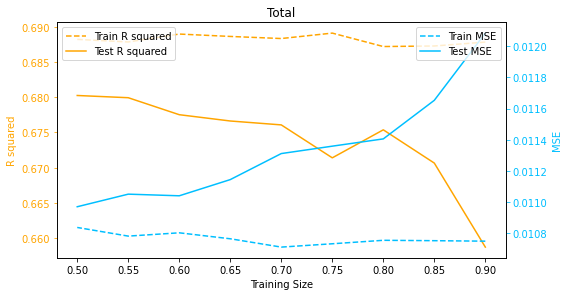

Avg R-Square for Training: 0.5825394624327779
Avg R-Square for Testing: 0.5732310682631846
Avg MSE for Training: 0.007454697276189696
Avg MSE for Testing: 0.007873046289794485


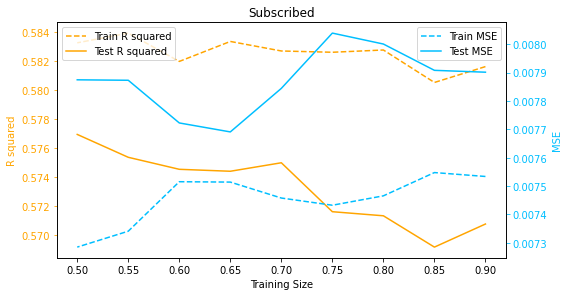

Avg R-Square for Training: 0.6813198503231814
Avg R-Square for Testing: 0.6698867330542809
Avg MSE for Training: 0.009327461172770994
Avg MSE for Testing: 0.009652263529185174


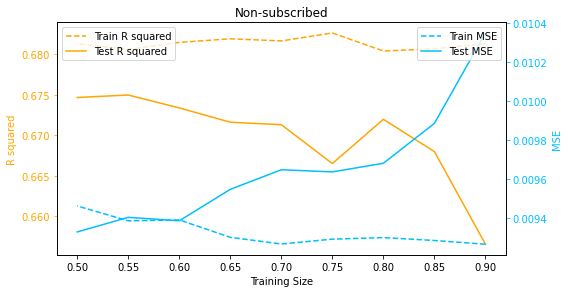

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Separate Target Variable and Predictor Variables
TargetVariable1 = 'Total'
TargetVariable2 = 'Subscribed'
TargetVariable3 = 'Non-subscribed'
original = ['year', 'feeling_temperature', 'temperature', 'windspeed', 'humidity',
              'season_fall', 'season_spring', 'season_summer', 'season_winter',
              'month_Apr', 'month_Aug', 'month_Dec',
              'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
              'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
              'weekday_weekend', 'weather_Clear or partly cloudy',
              'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
              'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
              'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
              'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
              'hour_22', 'hour_23']

model = train_predict(DataForML_Numeric, original, TargetVariable1)
train_predict(DataForML_Numeric, original, TargetVariable2)
train_predict(DataForML_Numeric, original, TargetVariable3)

## Coefficient importance

In [ ]:
#print(model.coef_)
coef_map = {
    'year': np.average(model.coef_[0: 1]),
    'feeling_temperature': np.average(model.coef_[1: 2]),
    'temperature': np.average(model.coef_[2: 3]),
    'windspeed': np.average(model.coef_[3: 4]),
    'humidity': np.average(model.coef_[4: 5]),
    'season': np.average(model.coef_[5: 9]),
    'month': np.average(model.coef_[9: 21]),
    'weekday': np.average(model.coef_[21: 23]),
    'weather': np.average(model.coef_[23: 26]),
    'hour': np.average(model.coef_[26: 50]),
}
pd.DataFrame(coef_map.items(), columns=['column_name', 'coefficient']).sort_values(by=['coefficient'], ascending=False)

,column_name,coefficient
5,season,2.537228e+12
7,weekday,2.240136e+12
8,weather,1.896929e+12
1,feeling_temperature,1.716136e-01
0,year,8.785443e-02
2,temperature,8.036259e-02
3,windspeed,-2.828406e-02
4,humidity,-9.282088e-02
9,hour,-3.047093e+10
6,month,-2.101248e+11


## Log transformation of y values

Avg R-Square for Training: 0.8237554160404977
Avg R-Square for Testing: 0.8154642116884535
Avg MSE for Training: 0.3893343842928157
Avg MSE for Testing: 0.4050640394406293


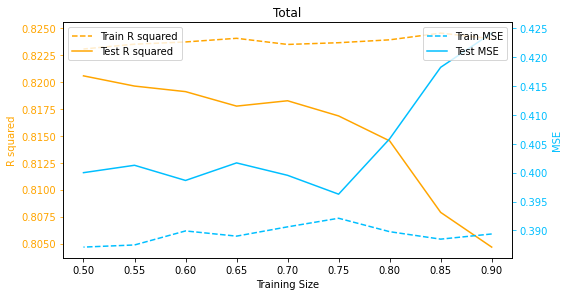

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# logarithmic transformation
df = pd.read_csv("data/Dataset.csv")
log_trans = np.log(df['Total'])
DataForML_Numeric['Total'] = log_trans

train_predict(DataForML_Numeric, original, TargetVariable1)

## Quantile Transformation of y values


Avg R-Square for Training: 0.7472608092367795
Avg R-Square for Testing: 0.7400806003371366
Avg MSE for Training: 0.29788630043086284
Avg MSE for Testing: 0.3059697406220642


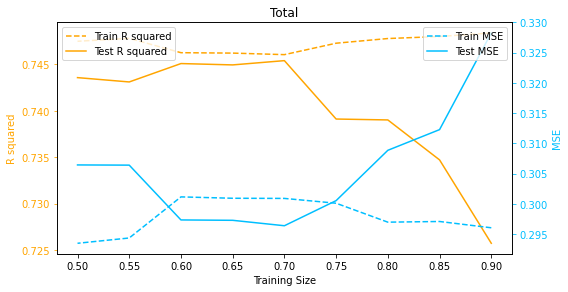

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# QuantileTransformation
df = pd.read_csv("data/Dataset.csv")
quantile_trans = quantile_transform(df['Total'].to_frame(),
                             n_quantiles=900,
                             output_distribution='normal',
                             copy=True).squeeze()
DataForML_Numeric['Total'] = quantile_trans
train_predict(DataForML_Numeric, original, TargetVariable1)

## Season not included in features for LR

season not included
Avg R-Square for Training: 0.6797969797076785
Avg R-Square for Testing: 0.665687674634513
Avg MSE for Training: 0.011055111053943047
Avg MSE for Testing: 0.01162732290066094


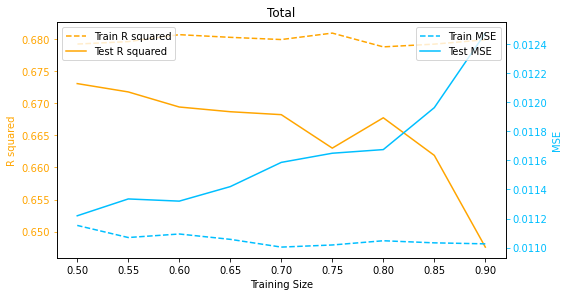

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
df = pd.read_csv("data/Dataset.csv")
# Normalise Total
min_max_scaler = MinMaxScaler()
total = min_max_scaler.fit_transform(df['Total'].to_numpy().reshape(-1, 1))
DataForML_Numeric['Total'] = total # using orignal value, no transformation
no_seasons = ['year', 'feeling_temperature', 'temperature', 'windspeed',
              'month_Apr', 'month_Aug', 'month_Dec',
              'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
              'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
              'weekday_weekend', 'weather_Clear or partly cloudy',
              'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
              'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
              'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
              'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
              'hour_22', 'hour_23']
print('season not included')
train_predict(DataForML_Numeric, no_seasons, TargetVariable1)

## feeling temperature vs temperature for in features for LR

feeling temp included
Avg R-Square for Training: 0.7471686749555546
Avg R-Square for Testing: 0.7400231312332277
Avg MSE for Training: 0.2979944480354132
Avg MSE for Testing: 0.30603938940319586


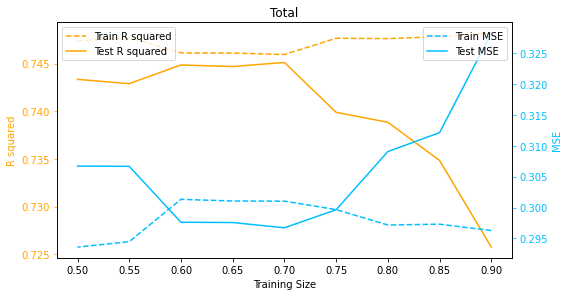

temp included
Avg R-Square for Training: 0.7469894806362195
Avg R-Square for Testing: 0.7398609664005539
Avg MSE for Training: 0.2982055909737098
Avg MSE for Testing: 0.30623162778340274


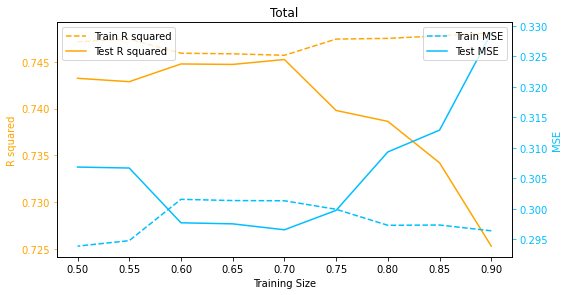

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
feeling_temperature = ['year', 'feeling_temperature', 'windspeed', 'humidity',
              'season_fall', 'season_spring', 'season_summer', 'season_winter',
              'month_Apr', 'month_Aug', 'month_Dec',
              'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
              'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
              'weekday_weekend', 'weather_Clear or partly cloudy',
              'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
              'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
              'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
              'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
              'hour_22', 'hour_23']

print('feeling temp included')
train_predict(DataForML_Numeric, feeling_temperature, TargetVariable1)

temperature = ['year', 'temperature', 'windspeed', 'humidity',
              'season_fall', 'season_spring', 'season_summer', 'season_winter',
              'month_Apr', 'month_Aug', 'month_Dec',
              'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
              'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
              'weekday_weekend', 'weather_Clear or partly cloudy',
              'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
              'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
              'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
              'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
              'hour_22', 'hour_23']
print('temp included')
train_predict(DataForML_Numeric, temperature, TargetVariable1)

## humidity vs no humidity in features for LR

humidity included
Avg R-Square for Training: 0.7472608092367795
Avg R-Square for Testing: 0.7400806003371366
Avg MSE for Training: 0.29788630043086284
Avg MSE for Testing: 0.3059697406220642


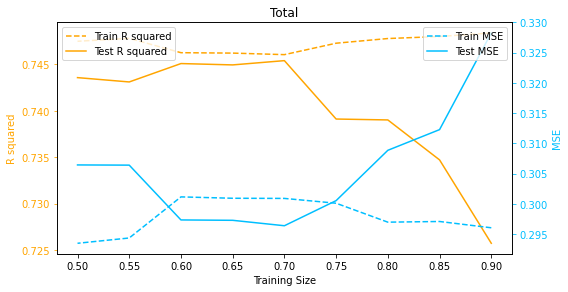

humidity not included
Avg R-Square for Training: 0.7458999939932043
Avg R-Square for Testing: 0.7386633528084662
Avg MSE for Training: 0.29948854363471455
Avg MSE for Testing: 0.3076389889972637


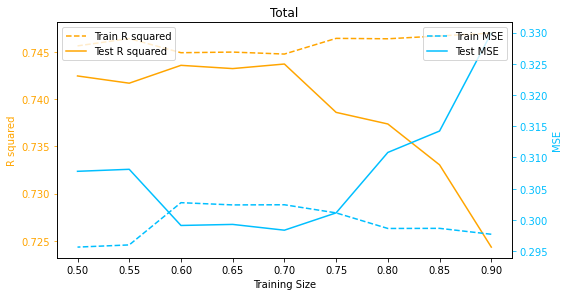

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
humidity = ['year', 'feeling_temperature', 'temperature', 'windspeed', 'humidity',
              'season_fall', 'season_spring', 'season_summer', 'season_winter',
              'month_Apr', 'month_Aug', 'month_Dec',
              'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
              'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
              'weekday_weekend', 'weather_Clear or partly cloudy',
              'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
              'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
              'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
              'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
              'hour_22', 'hour_23']
print('humidity included')
train_predict(DataForML_Numeric, humidity, TargetVariable1)

no_humidity = ['year', 'feeling_temperature', 'temperature', 'windspeed',
              'season_fall', 'season_spring', 'season_summer', 'season_winter',
              'month_Apr', 'month_Aug', 'month_Dec',
              'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
              'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
              'weekday_weekend', 'weather_Clear or partly cloudy',
              'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
              'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
              'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
              'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
              'hour_22', 'hour_23']
print('humidity not included')
train_predict(DataForML_Numeric, no_humidity, TargetVariable1)

## Cyclic Encoding on hour feature

Avg R-Square for Training: 0.5018278430951644
Avg R-Square for Testing: 0.48982433390708835
Avg MSE for Training: 0.017199583780170488
Avg MSE for Testing: 0.017742204938149646


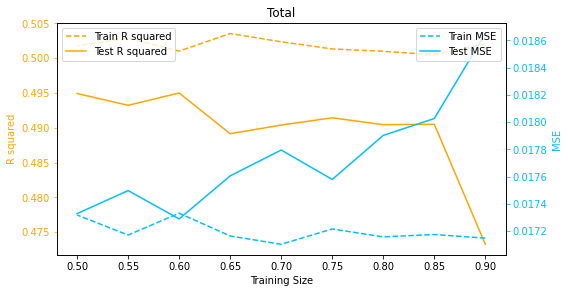

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# cyclic encoding
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# using cyclic encoding on hour
cyclic_DataForML = encode(DataForML, 'hour', 23.0)

# log transform
DataForML_Numeric['Total'] = log_trans

DataForML_Numeric=pd.get_dummies(DataForML, columns=['season', 'month', 'weekday', 'weather'])

TargetVariable1 = 'Total'

cyclic_original = ['year', 'feeling_temperature', 'temperature', 'windspeed', 'humidity', 
                  'season_fall', 'season_spring', 'season_summer', 'season_winter',
                  'month_Apr', 'month_Aug', 'month_Dec',
                  'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
                  'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
                  'weekday_weekend', 'weather_Clear or partly cloudy',
                  'weather_Light rain', 'weather_Mist', 'weekday_weekday',
                  'weekday_weekend', 'weather_Clear or partly cloudy',
                  'weather_Light rain', 'weather_Mist', 'hour_sin', 'hour_cos']

train_predict(DataForML_Numeric, cyclic_original, TargetVariable1)

## Grouping hours by 2 hours to reduce number of features

Avg R-Square for Training: 0.6371395708656693
Avg R-Square for Testing: 0.6231324513479767
Avg MSE for Training: 0.01252777587389352
Avg MSE for Testing: 0.013105941888279932


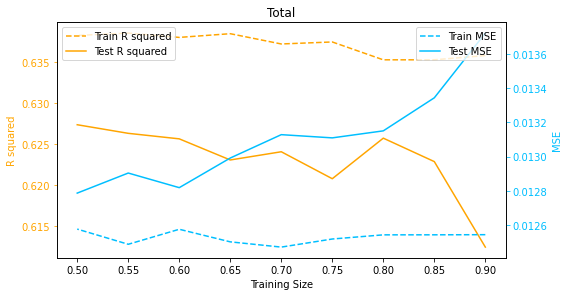

In [ ]:
df = pd.read_csv("data/Dataset.csv")

# reduce the number of hours from 24 to 12 using 2-hour range
df['hour'] = pd.cut(df.hour, 12, labels=range(12))

SelectedColumns = ['season', 'year', 'month', 'hour', 'weekday', 'weather', 'feeling_temperature', 'temperature', 'windspeed', 'humidity', 'Total', 'Subscribed', 'Non-subscribed']

# replacing heavy rain with light rain
df["weather"].replace({"Heavy rain": "Light rain"}, inplace=True)

# replacing Mon-Fri as weekday and Sat-Sun as weekend
df["weekday"].replace({
    "Sat": "weekend",
    "Sun": "weekend",
    "Fri": "weekday",
    "Thu": "weekday",
    "Wed": "weekday",
    "Tue": "weekday",
    "Mon": "weekday"},
  inplace=True)

#Normalise feeling_temperature to [0,1]
min_max_scaler = MinMaxScaler()
feeling_temperature = min_max_scaler.fit_transform(df['feeling_temperature'].to_numpy().reshape(-1, 1))
df['feeling_temperature'] = feeling_temperature

#Normalise temperature to [0,1]
min_max_scaler = MinMaxScaler()
temperature = min_max_scaler.fit_transform(df['temperature'].to_numpy().reshape(-1, 1))
df['temperature'] = temperature

#Normalise humidity to [0,1]
min_max_scaler = MinMaxScaler()
humidity = min_max_scaler.fit_transform(df['humidity'].to_numpy().reshape(-1, 1))
df['humidity'] = humidity

#Normalise windspeed to [0,1]
min_max_scaler = MinMaxScaler()
windspeed = min_max_scaler.fit_transform(df['windspeed'].to_numpy().reshape(-1, 1))
df['windspeed'] = windspeed

year = df['year'].to_numpy().reshape(-1, 1)
df['year'] = year

# Normalise Total
min_max_scaler = MinMaxScaler()
total = min_max_scaler.fit_transform(df['Total'].to_numpy().reshape(-1, 1))
df['Total'] = total

# Normalise Subscribed
min_max_scaler = MinMaxScaler()
subscribed = min_max_scaler.fit_transform(df['Subscribed'].to_numpy().reshape(-1, 1))
df['Subscribed'] = subscribed

# Normalise Non-subscribed
min_max_scaler = MinMaxScaler()
non_subscribed = min_max_scaler.fit_transform(df['Non-subscribed'].to_numpy().reshape(-1, 1))
df['Non-subscribed'] = non_subscribed

# Selecting final columns
DataForML = df[SelectedColumns]

# Treating all the nominal variables at once using dummy variables
# OneHotEncode
DataForML_Numeric=pd.get_dummies(DataForML, columns=['season', 'month', 'weekday', 'weather', 'hour'])

# Separate Target Variable and Predictor Variables
TargetVariable1 = 'Total'
original = ['year', 'feeling_temperature', 'temperature', 'windspeed', 'humidity',
              'season_fall', 'season_spring', 'season_summer', 'season_winter',
              'month_Apr', 'month_Aug', 'month_Dec',
              'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
              'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
              'weekday_weekend', 'weather_Clear or partly cloudy',
              'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
              'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
              'hour_10', 'hour_11']

model = train_predict(DataForML_Numeric, original, TargetVariable1)

# Decision Tree Regression Model

## Feature creation

In [ ]:
def get_x(data):

  # Weekday encoding
  data.loc[data['weekday'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri']), 'is_weekday'] = 1
  data.loc[data['weekday'].isin(['Sat', 'Sun']), 'is_weekend'] = 1
  data['is_weekday'].fillna(0, inplace=True)
  data['is_weekend'].fillna(0, inplace=True)

  #OneHotEncode season
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  season = enc.fit_transform(data['season'].to_numpy().reshape(-1, 1))

  #OneHotEncode weather
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  weather = enc.fit_transform(data['weather'].to_numpy().reshape(-1, 1))

  #OneHotEncode month
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  month = enc.fit_transform(data['month'].to_numpy().reshape(-1, 1))

  #OneHotEncode hour
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  hour = enc.fit_transform(data['hour'].to_numpy().reshape(-1, 1))

  #Normalise temperature to [0,1]
  min_max_scaler = MinMaxScaler()
  temperature = min_max_scaler.fit_transform(data['temperature'].to_numpy().reshape(-1, 1))

  #Normalise humidity to [0,1]
  min_max_scaler = MinMaxScaler()
  humidity = min_max_scaler.fit_transform(data['humidity'].to_numpy().reshape(-1, 1))

  #Normalise windspeed to [0,1]
  min_max_scaler = MinMaxScaler()
  windspeed = min_max_scaler.fit_transform(data['windspeed'].to_numpy().reshape(-1, 1))

  return np.concatenate((season, weather, data['year'].to_numpy().reshape(-1, 1), month, hour, data['is_weekday'].to_numpy().reshape(-1, 1), data['is_weekend'].to_numpy().reshape(-1, 1), temperature, humidity, windspeed), axis=1)


def get_y(data, y_column, transformation='minmax'):

  if transformation == 'minmax':

    min_max_scaler = MinMaxScaler()

    return min_max_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

  elif transformation == 'log':

    log_transformed = np.log(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

    log_transformed[log_transformed == -np.inf] = 0

    return log_transformed

  else:

    min_max_scaler = MinMaxScaler()

    return min_max_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

## Train decision tree model
Predict the bike rentals for a given hour by Subscribers

In [ ]:
def create_decision_tree_model(x, y, **kwargs):

  test_size= kwargs['test_size'] if 'test_size' in kwargs else 0.2
  max_depth = kwargs['max_depth'] if 'max_depth' in kwargs else 5
  min_samples_split = kwargs['min_samples_split'] if 'min_samples_split' in kwargs else 40
  min_samples_leaf = kwargs['min_samples_leaf'] if 'min_samples_leaf' in kwargs else 10

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

  model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  model_metrics = {
      'train_R_squared': r2_score(y_train, y_pred_train),
      'train_MSE': mean_squared_error(y_train, y_pred_train),
      'test_R_squared': r2_score(y_test, y_pred_test),
      'test_MSE': mean_squared_error(y_test, y_pred_test)
  }

  return model, model_metrics

x = get_x(data)
y = get_y(data, 'Subscribed', 'minmax')

model, model_metrics_subscribed = create_decision_tree_model(x, y)

## Check model performance

In [ ]:
model_metrics_subscribed

{'test_MSE': 0.007812921336241504,
 'test_R_squared': 0.5420366831454726,
 'train_MSE': 0.008028821326281398,
 'train_R_squared': 0.5610468317455045}

## Log transformed y model performance

In [ ]:
x = get_x(data)
y = get_y(data, 'Subscribed', 'log')

model, model_metrics_subscribed = create_model(x, y)

model_metrics_subscribed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


{'test_MSE': 1.1029831635814633,
 'test_R_squared': 0.5560795218580229,
 'train_MSE': 1.1452945134647181,
 'train_R_squared': 0.5509445022260429}

## Feature importance

In [ ]:
feature_importance_map = {
  'season': np.average(model.feature_importances_[0: 4]),
  'weather': np.average(model.feature_importances_[4: 7]),
  'year': np.average(model.feature_importances_[7: 8]),
  'month': np.average(model.feature_importances_[8: 20]),
  'hour': np.average(model.feature_importances_[20: 44]),
  'weekday': np.average(model.feature_importances_[44: 46]),
  'temperature': np.average(model.feature_importances_[46: 47]),
  'humidity': np.average(model.feature_importances_[47: 48]),
  'windspeed': np.average(model.feature_importances_[48: 49])
}

feature_importance_df = pd.DataFrame(feature_importance_map.items(), columns=['column_name', 'importance']).sort_values(by=['importance'], ascending=False)

feature_importance_df


,column_name,importance
6,temperature,0.429331
7,humidity,0.252082
4,hour,0.013039
5,weekday,0.002537
3,month,0.000049
0,season,0.000000
1,weather,0.000000
2,year,0.000000
8,windspeed,0.000000


## Decision tree hyperparameter tuning
Through modifying the various hyperparameters, we try and estimate a combination that will yield the best model for our data

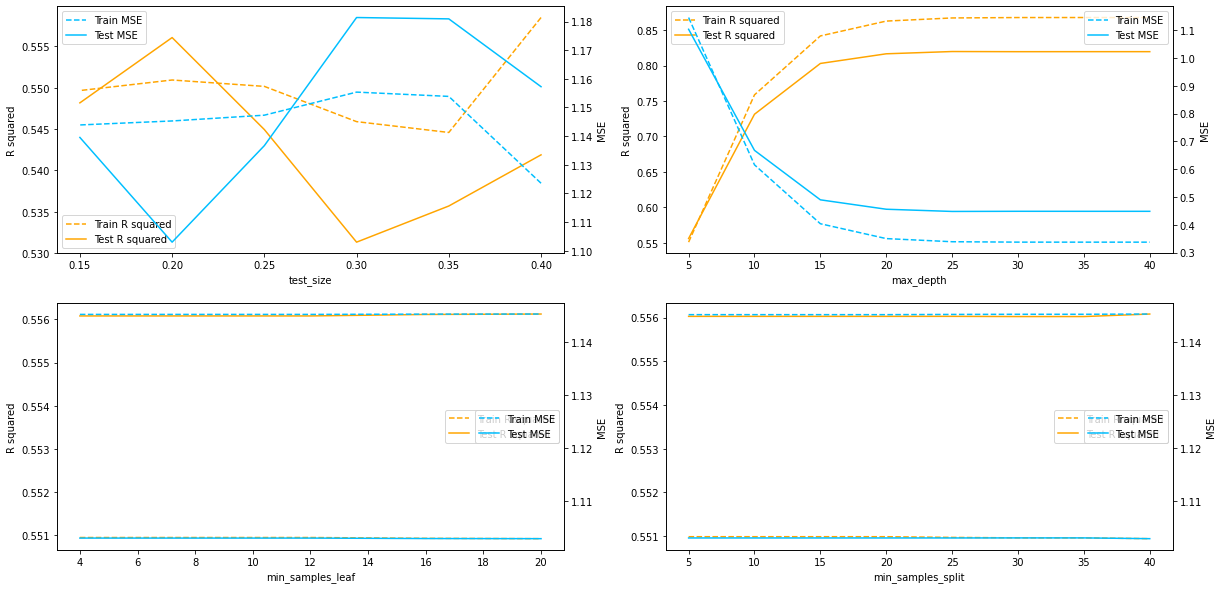

In [ ]:
param_grid = {
    'test_size': [0.4, 0.35, 0.3, 0.25, 0.2, 0.15],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40], 
    'min_samples_leaf': [4, 8, 12, 16, 20],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40]
}

metrics = {}

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for index, (param_name, param_list) in enumerate(param_grid.items()):

  metrics[param_name] = {}

  for param_value in param_list:

    kwargs = {'x': x, 'y': y, param_name: param_value}

    model, model_metrics = create_model(**kwargs)

    metrics[param_name][param_value] = dict(model_metrics)

  metrics_df = pd.DataFrame.from_dict(metrics[param_name]).transpose()

  ax[int(index/2), index%2].plot(np.array(metrics_df.index), metrics_df['train_R_squared'], color="orange", label="Train R squared", linestyle="dashed")
  ax[int(index/2), index%2].plot(np.array(metrics_df.index), metrics_df['test_R_squared'], color="orange", label="Test R squared")
  
  ax2 = ax[int(index/2), index%2].twinx()
  ax2.plot(np.array(metrics_df.index), metrics_df['train_MSE'], color='deepskyblue', label="Train MSE", linestyle="dashed")
  ax2.plot(np.array(metrics_df.index), metrics_df['test_MSE'], color='deepskyblue', label="Test MSE")
  ax2.set_ylabel('MSE')
  ax2.legend()

  ax[int(index/2), index%2].set_xlabel(param_name)
  ax[int(index/2), index%2].set_ylabel("R squared")
  ax[int(index/2), index%2].legend()

plt.show()

The following values for hyperparameters appear to work best
- test_size : 0.3
- max_depth : 25
- min_samples_split : 20
- min_samples_leaf : 8

Tuning the max_depth of the tree has the most effect on model error and performance

## Train model to predict Non-subscribed customers

### Using same hyperparameter values as base model

In [ ]:
x = get_x(data)
y = get_y(data, 'Non-subscribed', 'log')

model, model_metrics_non_subscribed_base = create_decision_tree_model(x, y, test_size=0.2, max_depth=5, min_samples_split=40, min_samples_leaf=10)

model_metrics_non_subscribed_base

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


{'test_MSE': 0.800469661072796,
 'test_R_squared': 0.6260893011915322,
 'train_MSE': 0.8270115138984692,
 'train_R_squared': 0.6210516987017511}

Using optimised hyperparameter values, we train the model to predict non subscribers and check for changes in R squared and MSE

In [ ]:
x = get_x(data)
y = get_y(data, 'Non-subscribed', 'log')

model, model_metrics_non_subscribed = create_decision_tree_model(x, y, test_size=0.3, max_depth=25, min_samples_split=20, min_samples_leaf=8)

model_metrics_non_subscribed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


{'test_MSE': 0.22967614411963747,
 'test_R_squared': 0.894610941056397,
 'train_MSE': 0.15606431355435593,
 'train_R_squared': 0.9281333295334078}

## Difference in model performance when predicting Subscribed vs Non-subscribed customers

In [ ]:
difference_df = pd.DataFrame.from_dict({'Subscribed': model_metrics_subscribed, 'Non-subscribed': model_metrics_non_subscribed})

difference_df['difference_percentage'] = (100 * (difference_df['Non-subscribed'] - difference_df['Subscribed']))/difference_df['Subscribed']

difference_df


,Subscribed,Non-subscribed,difference_percentage
train_R_squared,0.550945,0.928133,68.462218
train_MSE,1.145295,0.156064,-86.373434
test_R_squared,0.556080,0.894611,60.878239
test_MSE,1.102983,0.229676,-79.176822


# Train model to predict Total customers

In [ ]:
x = get_x(data)
y = get_y(data, 'Total', 'log')

model, model_metrics_total = create_decision_tree_model(x, y, test_size=0.3, max_depth=25, min_samples_split=20, min_samples_leaf=8)

model_metrics_total

{'test_MSE': 0.22156708713205583,
 'test_R_squared': 0.9000073348589134,
 'train_MSE': 0.1378787732737565,
 'train_R_squared': 0.9374706617825166}

In [ ]:
feature_importance_map = {
  'season': np.average(model.feature_importances_[0: 4]),
  'weather': np.average(model.feature_importances_[4: 7]),
  'year': np.average(model.feature_importances_[7: 8]),
  'month': np.average(model.feature_importances_[8: 20]),
  'hour': np.average(model.feature_importances_[20: 44]),
  'weekday': np.average(model.feature_importances_[44: 46]),
  'temperature': np.average(model.feature_importances_[46: 47]),
  'humidity': np.average(model.feature_importances_[47: 48]),
  'windspeed': np.average(model.feature_importances_[48: 49])
}

feature_importance_df = pd.DataFrame(feature_importance_map.items(), columns=['column_name', 'importance']).sort_values(by=['importance'], ascending=False)

feature_importance_df

,column_name,importance
6,temperature,0.088353
5,weekday,0.035179
4,hour,0.031650
2,year,0.028122
7,humidity,0.017525
0,season,0.004750
1,weather,0.003208
8,windspeed,0.002652
3,month,0.000397


## Tree structure

In [ ]:
print(export_text(model))

|--- feature_46 <= 0.38
|   |--- feature_46 <= 0.26
|   |   |--- feature_25 <= 0.50
|   |   |   |--- feature_24 <= 0.50
|   |   |   |   |--- feature_26 <= 0.50
|   |   |   |   |   |--- value: [1.25]
|   |   |   |   |--- feature_26 >  0.50
|   |   |   |   |   |--- value: [0.35]
|   |   |   |--- feature_24 >  0.50
|   |   |   |   |--- feature_45 <= 0.50
|   |   |   |   |   |--- value: [0.02]
|   |   |   |   |--- feature_45 >  0.50
|   |   |   |   |   |--- value: [0.17]
|   |   |--- feature_25 >  0.50
|   |   |   |--- feature_46 <= 0.23
|   |   |   |   |--- feature_15 <= 0.50
|   |   |   |   |   |--- value: [0.01]
|   |   |   |   |--- feature_15 >  0.50
|   |   |   |   |   |--- value: [0.09]
|   |   |   |--- feature_46 >  0.23
|   |   |   |   |--- value: [0.18]
|   |--- feature_46 >  0.26
|   |   |--- feature_47 <= 0.59
|   |   |   |--- feature_25 <= 0.50
|   |   |   |   |--- feature_24 <= 0.50
|   |   |   |   |   |--- value: [2.53]
|   |   |   |   |--- feature_24 >  0.50
|   |   |   |   

# Classification Models

## OneVsRest

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

def OvR(X_train, X_test, y_train, y_test):
  # define model
  OvR_clf = OneVsRestClassifier(LogisticRegression())
  # fit model
  OvR_clf.fit(X_train, y_train)
  # make predictions
  y_pred = OvR_clf.predict(X_test)

  print(classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5]))
  print(accuracy_score(y_test, y_pred))

## OneVsOne

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression

def OvO(X_train, X_test, y_train, y_test):
  # define model
  OvO_clf = OneVsOneClassifier(LogisticRegression())
  # fit model
  OvO_clf.fit(X_train, y_train)
  # make predictions
  y_pred = OvO_clf.predict(X_test)

  print(classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5]))
  print(accuracy_score(y_test, y_pred))

## Execution of classification models

To transform the problem of regression into classification with five classess we decided to divide the data into bins based on target value which is 'Total' using pandas.cut.

Similarly we also exeprimented with pandas.qcut which divide the data into buckets based on sample quantile.

In [ ]:
# read data
df = pd.read_csv("data/Dataset.csv")
df['Category'] = pd.cut(df.Total, 5, labels=[1, 2, 3, 4, 5])
df['Category_Percentile'] = pd.qcut(df.Total, 5, labels=[1, 2, 3, 4, 5])

In [ ]:
def preprocessing(DataForML):
  SelectedColumns = ['season', 'year', 'month', 'hour', 'weekday', 'weather', 'feeling_temperature', 'temperature', 'windspeed', 'humidity', 'Total', 'Subscribed', 'Non-subscribed', 'Category', 'Category_Percentile']

  # replacing heavy rain with light rain
  DataForML["weather"].replace({"Heavy rain": "Light rain"}, inplace=True)

  # replacing Mon-Fri as weekday and Sat-Sun as weekend
  DataForML["weekday"].replace({
      "Sat": "weekend",
      "Sun": "weekend",
      "Fri": "weekday",
      "Thu": "weekday",
      "Wed": "weekday",
      "Tue": "weekday",
      "Mon": "weekday"},
    inplace=True)

  #Normalise feeling_temperature to [0,1]
  min_max_scaler = MinMaxScaler()
  feeling_temperature = min_max_scaler.fit_transform(DataForML['feeling_temperature'].to_numpy().reshape(-1, 1))
  DataForML['feeling_temperature'] = feeling_temperature

  #Normalise temperature to [0,1]
  min_max_scaler = MinMaxScaler()
  temperature = min_max_scaler.fit_transform(DataForML['temperature'].to_numpy().reshape(-1, 1))
  DataForML['temperature'] = temperature

  #Normalise humidity to [0,1]
  min_max_scaler = MinMaxScaler()
  humidity = min_max_scaler.fit_transform(DataForML['humidity'].to_numpy().reshape(-1, 1))
  DataForML['humidity'] = humidity

  #Normalise windspeed to [0,1]
  min_max_scaler = MinMaxScaler()
  windspeed = min_max_scaler.fit_transform(DataForML['windspeed'].to_numpy().reshape(-1, 1))
  DataForML['windspeed'] = windspeed

  year = DataForML['year'].to_numpy().reshape(-1, 1)
  DataForML['year'] = year

  # Normalise Total
  min_max_scaler = MinMaxScaler()
  total = min_max_scaler.fit_transform(DataForML['Total'].to_numpy().reshape(-1, 1))
  DataForML['Total'] = total

  # Normalise Subscribed
  min_max_scaler = MinMaxScaler()
  subscribed = min_max_scaler.fit_transform(DataForML['Subscribed'].to_numpy().reshape(-1, 1))
  DataForML['Subscribed'] = subscribed

  # Normalise Non-subscribed
  min_max_scaler = MinMaxScaler()
  non_subscribed = min_max_scaler.fit_transform(DataForML['Non-subscribed'].to_numpy().reshape(-1, 1))
  DataForML['Non-subscribed'] = non_subscribed

  # Selecting final columns
  DataForML = DataForML[SelectedColumns]
  print(DataForML.dtypes)
  return DataForML

def onehotencoding(DataForML):
  # Treating all the nominal variables at once using dummy variables
  # OneHotEncode
  DataForML_Numeric=pd.get_dummies(DataForML, columns=['season', 'month', 'weekday', 'weather', 'hour'])

  # Printing sample rows
  print(DataForML_Numeric.head())

  # Printing all the column names for our reference
  print(DataForML_Numeric.columns)
  return DataForML_Numeric

In [ ]:
# logistic regression for multi-class classification using built-in one-vs-rest
from sklearn.metrics import classification_report, accuracy_score
keys = ['year', 'feeling_temperature', 'temperature', 'windspeed', 'humidity',
        'season_fall', 'season_spring', 'season_summer', 'season_winter',
        'month_Apr', 'month_Aug', 'month_Dec',
        'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
        'month_May', 'month_Nov', 'month_Oct', 'month_Sep', 'weekday_weekday',
        'weekday_weekend', 'weather_Clear or partly cloudy',
        'weather_Light rain', 'weather_Mist', 'hour_0', 'hour_1', 'hour_2',
        'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
        'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
        'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
        'hour_22', 'hour_23']

DataForML = df.copy()
DataForML = preprocessing(DataForML)
DataForML_Numeric = onehotencoding(DataForML)
X = DataForML_Numeric[keys].values

season                   object
year                      int64
month                    object
hour                      int64
weekday                  object
weather                  object
feeling_temperature     float64
temperature             float64
windspeed               float64
humidity                float64
Total                   float64
Subscribed              float64
Non-subscribed          float64
Category               category
Category_Percentile    category
dtype: object
   year  feeling_temperature  temperature  ...  hour_21  hour_22  hour_23
0     0               0.2879     0.224490  ...        0        0        0
1     0               0.2727     0.204082  ...        0        0        0
2     0               0.2727     0.204082  ...        0        0        0
3     0               0.2879     0.224490  ...        0        0        0
4     0               0.2879     0.224490  ...        0        0        0

[5 rows x 55 columns]
Index(['year', 'feeling_temperature', '

In [ ]:
# Bin values into discrete intervals
y_cat = DataForML_Numeric['Category'].values
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=428)

In [ ]:
%%time
OvR(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           1       0.85      0.91      0.88      3211
           2       0.57      0.62      0.60      1288
           3       0.46      0.25      0.32       492
           4       0.53      0.28      0.37       164
           5       0.78      0.42      0.55        59

    accuracy                           0.75      5214
   macro avg       0.64      0.50      0.54      5214
weighted avg       0.74      0.75      0.74      5214

0.7514384349827388
CPU times: user 1.62 s, sys: 854 ms, total: 2.48 s
Wall time: 1.31 s


In [ ]:
%%time
OvO(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           1       0.88      0.89      0.88      3211
           2       0.62      0.66      0.64      1288
           3       0.53      0.43      0.47       492
           4       0.50      0.40      0.45       164
           5       0.67      0.56      0.61        59

    accuracy                           0.77      5214
   macro avg       0.64      0.59      0.61      5214
weighted avg       0.77      0.77      0.77      5214

0.7706175680859225
CPU times: user 1.27 s, sys: 763 ms, total: 2.04 s
Wall time: 1.07 s


In [ ]:
# Quantile-based discretization function
y_cat_per = DataForML_Numeric['Category_Percentile'].values
X_train, X_test, y_train, y_test = train_test_split(X, y_cat_per, test_size=0.3, random_state=428)

In [ ]:
%%time
OvR(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           1       0.78      0.80      0.79      1058
           2       0.53      0.47      0.50      1023
           3       0.50      0.43      0.46      1051
           4       0.48      0.53      0.50      1039
           5       0.67      0.77      0.72      1043

    accuracy                           0.60      5214
   macro avg       0.59      0.60      0.59      5214
weighted avg       0.59      0.60      0.60      5214

0.5999232834675873
CPU times: user 1.9 s, sys: 1.01 s, total: 2.91 s
Wall time: 1.52 s


In [ ]:
%%time
OvO(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           1       0.78      0.81      0.79      1058
           2       0.58      0.57      0.57      1023
           3       0.55      0.54      0.55      1051
           4       0.56      0.55      0.55      1039
           5       0.73      0.75      0.74      1043

    accuracy                           0.64      5214
   macro avg       0.64      0.64      0.64      5214
weighted avg       0.64      0.64      0.64      5214

0.6434599156118144
CPU times: user 1.51 s, sys: 915 ms, total: 2.42 s
Wall time: 1.26 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Perceptron Method 

In [ ]:
# Initialising data
def get_x_perceptron(data):
  #OneHotEncode season
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  season = enc.fit_transform(data['season'].to_numpy().reshape(-1, 1))

  #OneHotEncode month
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  month = enc.fit_transform(data['month'].to_numpy().reshape(-1, 1))

  #OneHotEncode hour
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  hour = enc.fit_transform(data['hour'].to_numpy().reshape(-1, 1))

  #Normalise temperature to [0,1]
  min_max_scaler = MinMaxScaler()
  temperature = min_max_scaler.fit_transform(data['temperature'].to_numpy().reshape(-1, 1))

  #Normalise humidity to [0,1]
  min_max_scaler = MinMaxScaler()
  humidity = min_max_scaler.fit_transform(data['humidity'].to_numpy().reshape(-1, 1))

  #Normalise windspeed to [0,1]
  min_max_scaler = MinMaxScaler()
  windspeed = min_max_scaler.fit_transform(data['windspeed'].to_numpy().reshape(-1, 1))

  #Subscribers
  min_max_scaler = MinMaxScaler()
  subscribers = min_max_scaler.fit_transform(data['Subscribed'].to_numpy().reshape(-1, 1))
  
  #Non-Subscribers
  min_max_scaler = MinMaxScaler()
  non_subscribers = min_max_scaler.fit_transform(data['Non-subscribed'].to_numpy().reshape(-1, 1))

  return np.concatenate((season, data['year'].to_numpy().reshape(-1, 1), month, hour, 
                         data['is_weekday'].to_numpy().reshape(-1, 1), 
                         data['is_weekend'].to_numpy().reshape(-1, 1), temperature, 
                         humidity, windspeed, ), axis=1)

def get_y_perceptron(data):
  data["weather"].replace(to_replace="Clear or partly cloudy", value=0, inplace=True)
  data["weather"].replace(to_replace="Mist", value=1, inplace=True)
  data["weather"].replace(to_replace="Light rain", value=2, inplace=True)
  data["weather"].replace(to_replace="Heavy rain", value=3, inplace=True)
  weather = data['weather'].to_numpy().reshape(-1, 1)
  return weather
  
data.loc[data['weekday'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri']), 'is_weekday'] = 1
data.loc[data['weekday'].isin(['Sat', 'Sun']), 'is_weekend'] = 1
data['is_weekday'].fillna(0, inplace=True)
data['is_weekend'].fillna(0, inplace=True)

In [ ]:
# Perceptron for multi-class classification using one-vs-one
x = get_x_perceptron(data)
y = get_y_perceptron(data)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# define model
model = MLPClassifier(learning_rate_init=0.01, learning_rate='constant', random_state=42, early_stopping=False)
# define ovo strategy
ovo = OneVsOneClassifier(model)
# fit model
ovo.fit(X_train, y_train)
# scores
print("train:",ovo.score(X_train, y_train))
print("test:",ovo.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


train: 0.8457167517801913
test: 0.6573647871116226


# Outlier Detection

In the dataset given, majority of features are categorical and only few are numerical. So we decided to use histogram for categorical features and box plor for numerical features to detect outliers. Histogram are shown in the section '**EDA**' of this notebook and box plots are shown as follows.

We can see in the following box plot that, 'humidity' and 'windspeed' contains some outliers while 'temperature' and 'feeling_temperature' do not.

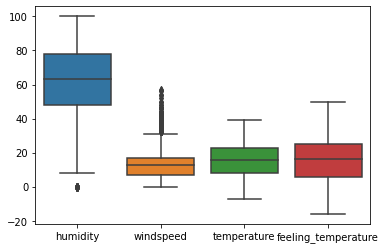

In [ ]:
# read data
df = pd.read_csv("data/Dataset.csv")

# visualizaing outliers before scaling
sns.boxplot(data=df[['humidity', 'windspeed', 'temperature', 'feeling_temperature']])

# SVM Regressor Model

## Feature creation

In [ ]:
def get_x(data):

  # Weekday encoding
  data.loc[data['weekday'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri']), 'is_weekday'] = 1
  data.loc[data['weekday'].isin(['Sat', 'Sun']), 'is_weekend'] = 1
  data['is_weekday'].fillna(0, inplace=True)
  data['is_weekend'].fillna(0, inplace=True)

  #OneHotEncode season
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  season = enc.fit_transform(data['season'].to_numpy().reshape(-1, 1))

  #OneHotEncode weather
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  weather = enc.fit_transform(data['weather'].to_numpy().reshape(-1, 1))

  #OneHotEncode month
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  month = enc.fit_transform(data['month'].to_numpy().reshape(-1, 1))

  #OneHotEncode hour
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  hour = enc.fit_transform(data['hour'].to_numpy().reshape(-1, 1))

  #Normalise temperature to [0,1]
  min_max_scaler = MinMaxScaler()
  temperature = min_max_scaler.fit_transform(data['temperature'].to_numpy().reshape(-1, 1))

  #Normalise humidity to [0,1]
  min_max_scaler = MinMaxScaler()
  humidity = min_max_scaler.fit_transform(data['humidity'].to_numpy().reshape(-1, 1))

  #Normalise windspeed to [0,1]
  min_max_scaler = MinMaxScaler()
  windspeed = min_max_scaler.fit_transform(data['windspeed'].to_numpy().reshape(-1, 1))

  return np.concatenate((season, weather, data['year'].to_numpy().reshape(-1, 1), month, hour, data['is_weekday'].to_numpy().reshape(-1, 1), data['is_weekend'].to_numpy().reshape(-1, 1), temperature, humidity, windspeed), axis=1)


def get_y(data, y_column, transformation='minmax'):

  if transformation == 'minmax':

    min_max_scaler = MinMaxScaler()

    return min_max_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

  elif transformation == 'log':

    log_transformed = np.log(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

    log_transformed[log_transformed == -np.inf] = 0

    return log_transformed

  else:

    min_max_scaler = MinMaxScaler()

    return min_max_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

## Train model

In [ ]:
def train_svr_model(X_train, X_test, y_train, y_test, **kwargs):

  kernel = kwargs["kernel"] if "kernel" in kwargs else "rbf"
  c = kwargs['c'] if 'c' in kwargs else 1.0

  model = SVR(kernel=kernel)

  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  model_metrics = {
      'model': model,
      'train_R_squared': r2_score(y_train, y_pred_train),
      'train_MSE': mean_squared_error(y_train, y_pred_train),
      'test_R_squared': r2_score(y_test, y_pred_test),
      'test_MSE': mean_squared_error(y_test, y_pred_test)
  }

  return model_metrics

In [ ]:
X = get_x(data)
y = get_y(data, 'Subscribed', 'log')
metrics = {}

kf = KFold(n_splits=5)

for index, (train_index, test_index) in enumerate(kf.split(X)):
  print("index : ", index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  kwargs = {"X_train" : X_train, "X_test" : X_test, "y_train" : y_train, "y_test" : y_test, "c" : .01}

  metrics[index] = train_svr_model(**kwargs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


index :  0
index :  1
index :  2
index :  3
index :  4


## Kernel selection

In [ ]:
param_grid = {
  'kernel': ["linear", "poly", "rbf", "sigmoid"]
}

X = get_x(data)
y = get_y(data, 'Subscribed', 'log')
metrics = {}

kf = KFold(n_splits=5)

for param_name, param_values in param_grid.items():
  metrics[param_name] = {}

  for param_value in param_values:
    print(param_name, " : ", param_value)
    metrics[param_name][param_value] = {}

    for index, (train_index, test_index) in enumerate(kf.split(X)):
      print("\tindex : ", index)

      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      kwargs = {"X_train" : X_train, "X_test" : X_test, "y_train" : y_train, "y_test" : y_test, param_name : param_value}
      metrics[param_name][param_value][index] = train_svr_model(**kwargs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


kernel  :  linear
	index :  0
	index :  1
	index :  2
	index :  3
	index :  4
kernel  :  poly
	index :  0
	index :  1
	index :  2
	index :  3
	index :  4
kernel  :  rbf
	index :  0
	index :  1
	index :  2
	index :  3
	index :  4
kernel  :  sigmoid
	index :  0
	index :  1
	index :  2
	index :  3
	index :  4


In [ ]:
average_metrics = {}

for index, param_value in enumerate(param_grid["kernel"]):

  average_metrics[index] = {"kernel": param_value}

  average_metrics[index]["train_mse"] = np.average([fold_metrics["train_MSE"] for fold, fold_metrics in metrics["kernel"][param_value].items()])
  average_metrics[index]["test_mse"] = np.average([fold_metrics["test_MSE"] for fold, fold_metrics in metrics["kernel"][param_value].items()])
  average_metrics[index]["train_R_squared"] = np.average([fold_metrics["train_R_squared"] for fold, fold_metrics in metrics["kernel"][param_value].items()])
  average_metrics[index]["test_R_squared"] = np.average([fold_metrics["test_R_squared"] for fold, fold_metrics in metrics["kernel"][param_value].items()])

metrics_df = pd.DataFrame.from_dict(average_metrics).transpose()

metrics_df

,kernel,train_mse,test_mse,train_R_squared,test_R_squared
0,linear,0.473385,0.527805,0.812078,0.76225
1,poly,0.271312,0.545692,0.892281,0.75262
2,rbf,0.275611,0.408538,0.890574,0.816634
3,sigmoid,2291.05,829.016,-910.337,-372.581


# Dimensionality reduction with PCA

In [ ]:
#Initialising
def get_x_pca(data):
  data_transformed = data.copy()
  data_transformed = data_transformed.drop(["instant","Subscribed", "Non-subscribed", "Total"], axis=1)
  columns = ["date", "season", "month", "weekday", "weather"]
  for column in columns:
    data_transformed[column] = pd.factorize(data[column])[0]
  return data_transformed.to_numpy()

def get_y_pca(data, column):
  return data[column].to_numpy()

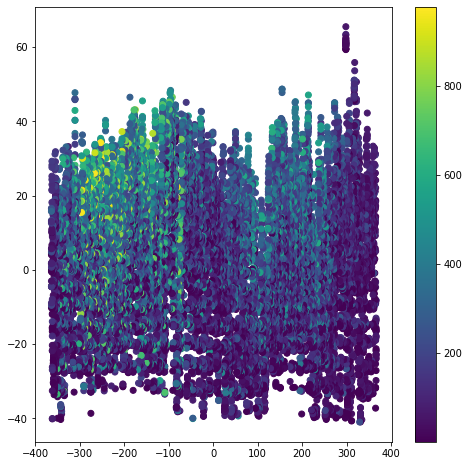

In [ ]:
#PCA
X_pca = get_x_pca(data)
y_pca = get_y_pca(data, "Total")
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca)
plt.colorbar()
plt.show()

# Hierarchical clustering and PCA

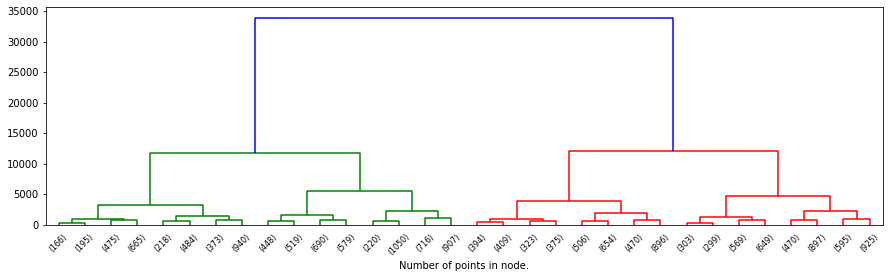

In [ ]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = get_x_pca(data)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(X)
plt.figure(figsize=(15, 4))
# plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node.")
plt.show()

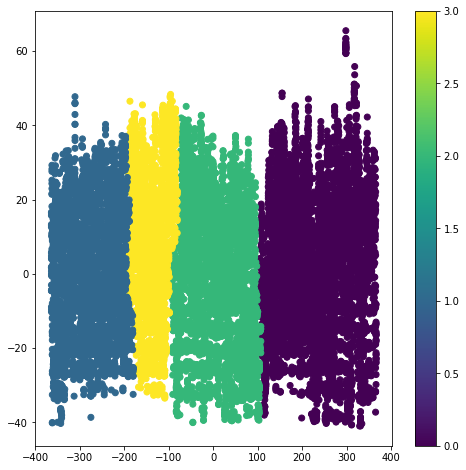

In [ ]:
# First PCA -> Then Clustering
X = get_x_pca(data)
y = get_y_pca(data, "Total")

pca = decomposition.PCA(n_components=2)
X_decomposed = pca.fit_transform(X)
clustering = AgglomerativeClustering(n_clusters=4).fit(X_decomposed) # Applying clustering to the decomposed X.
labels = clustering.labels_
plt.figure(figsize=(8, 8))
plt.scatter(X_decomposed[:, 0], X_decomposed[:, 1], c=labels)
plt.colorbar()
plt.show()

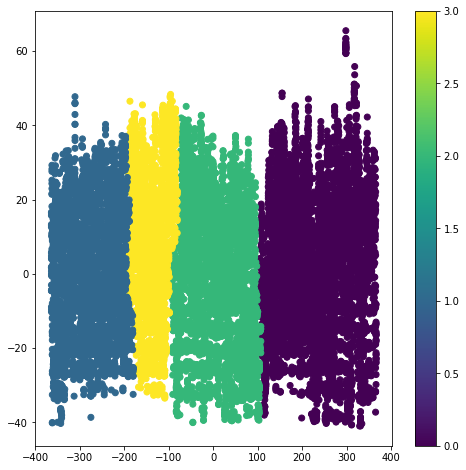

In [ ]:
# First Clustering -> Then PCA
X = get_x_pca(data)
y = get_y_pca(data, "Total")
AgglomerativeClustering(n_clusters=3).fit(X) 
pca = decomposition.PCA(n_components=2)
X_decomposed = pca.fit_transform(X)
labels = clustering.labels_
plt.figure(figsize=(8, 8))
plt.scatter(X_decomposed[:, 0], X_decomposed[:, 1], c=labels)
plt.colorbar()
plt.show()

# Random Forest Regressor

## Feature creation

In [ ]:
def get_x(data):

  # Weekday encoding
  data.loc[data['weekday'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri']), 'is_weekday'] = 1
  data.loc[data['weekday'].isin(['Sat', 'Sun']), 'is_weekend'] = 1
  data['is_weekday'].fillna(0, inplace=True)
  data['is_weekend'].fillna(0, inplace=True)

  #OneHotEncode season
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  season = enc.fit_transform(data['season'].to_numpy().reshape(-1, 1))

  #OneHotEncode weather
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  weather = enc.fit_transform(data['weather'].to_numpy().reshape(-1, 1))

  #OneHotEncode month
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  month = enc.fit_transform(data['month'].to_numpy().reshape(-1, 1))

  #OneHotEncode hour
  enc = OneHotEncoder(handle_unknown='error', sparse=False)
  hour = enc.fit_transform(data['hour'].to_numpy().reshape(-1, 1))

  #Normalise temperature to [0,1]
  min_max_scaler = MinMaxScaler()
  temperature = min_max_scaler.fit_transform(data['temperature'].to_numpy().reshape(-1, 1))

  #Normalise humidity to [0,1]
  min_max_scaler = MinMaxScaler()
  humidity = min_max_scaler.fit_transform(data['humidity'].to_numpy().reshape(-1, 1))

  #Normalise windspeed to [0,1]
  min_max_scaler = MinMaxScaler()
  windspeed = min_max_scaler.fit_transform(data['windspeed'].to_numpy().reshape(-1, 1))

  return np.concatenate((season, weather, data['year'].to_numpy().reshape(-1, 1), month, hour, data['is_weekday'].to_numpy().reshape(-1, 1), data['is_weekend'].to_numpy().reshape(-1, 1), temperature, humidity, windspeed), axis=1)


def get_y(data, y_column, transformation='minmax'):

  if transformation == 'minmax':

    min_max_scaler = MinMaxScaler()

    return min_max_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

  elif transformation == 'log':

    log_transformed = np.log(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

    log_transformed[log_transformed == -np.inf] = 0

    return log_transformed

  else:

    min_max_scaler = MinMaxScaler()

    return min_max_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

## Train Random Forest Regressor Model

In [ ]:
def train_RF_model(X, y, test_size, **kwargs):

  kernel = kwargs["kernel"] if "kernel" in kwargs else "rbf"
  test_size= kwargs['test_size'] if 'test_size' in kwargs else 0.2
  # max_depth = kwargs['max_depth'] if 'max_depth' in kwargs else 5
  # min_samples_split = kwargs['min_samples_split'] if 'min_samples_split' in kwargs else 40
  # min_samples_leaf = kwargs['min_samples_leaf'] if 'min_samples_leaf' in kwargs else 10

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  model = RandomForestRegressor(max_depth=2, oob_score=True, random_state=42)

  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  model_metrics = {
      'model': model,
      'oob_error': model.oob_score_,
      'train_R_squared': r2_score(y_train, y_pred_train),
      'train_MSE': mean_squared_error(y_train, y_pred_train),
      'test_R_squared': r2_score(y_test, y_pred_test),
      'test_MSE': mean_squared_error(y_test, y_pred_test)
  }

  return model_metrics

In [ ]:
X = get_x(data)
y = get_y(data, 'Total', 'log')

kwargs = {"X" : X, "y" : y, "test_size": 0.2}

metrics = train_RF_model(**kwargs)

metrics

{'model': RandomForestRegressor(max_depth=2, oob_score=True, random_state=42),
 'oob_error': 0.30188996585036953,
 'test_MSE': 1.4564902925036558,
 'test_R_squared': 0.3266764239778085,
 'train_MSE': 1.5491453354207436,
 'train_R_squared': 0.30211231851586684}

## Hyperparameter Tuning

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40], 
    'max_features': ['auto', 'sqrt'],
    'oob_score': [True],
    'min_samples_leaf': [4, 8, 12, 16, 20],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40],
    'n_estimators': [200, 400, 600, 800, 1000]
}

X = get_x(data)
y = get_y(data, 'Total', 'log')

# Base random forest model to tune
rf = RandomForestRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random search of parameters, using 5 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 8, 12, 16, 20],
                                        'min_samples_split': [5, 10, 15, 20, 25,
                                                              30, 35, 40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000],
                                        'oob_score': [True]},
                   random_state=42, verbose=2)

In [ ]:
model = rf_random.best_estimator_

model

RandomForestRegressor(max_depth=25, min_samples_leaf=4, min_samples_split=40,
                      n_estimators=800, oob_score=True)

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("OOB score : ", rf_random.best_estimator_.oob_score_)
print("Train MSE : ", mean_squared_error(y_train, y_pred_train))
print("Test MSE : ", mean_squared_error(y_test, y_pred_test))
print("Train R squared : ", r2_score(y_train, y_pred_train))
print("Test R squared : ", r2_score(y_test, y_pred_test))

OOB score :  0.9176978740155262
Train MSE :  0.14469324638824876
Test MSE :  0.18232297088751628
Train R squared :  0.9343802332558282
Test R squared :  0.9177181051054857


## Tree structure of estimator

In [ ]:
print(export_text(rf_random.best_estimator_.estimators_[0]))

|--- feature_24 <= 0.50
|   |--- feature_23 <= 0.50
|   |   |--- feature_22 <= 0.50
|   |   |   |--- feature_25 <= 0.50
|   |   |   |   |--- feature_21 <= 0.50
|   |   |   |   |   |--- feature_46 <= 0.40
|   |   |   |   |   |   |--- feature_26 <= 0.50
|   |   |   |   |   |   |   |--- feature_20 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_7 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_43 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |   |   |   |   |   |--- feature_43 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- feature_3 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_43 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |   |   |   |   |   |--- feature_43 >  0.50
|   |   |   |   |   |   |   |   | 